In [94]:
import pandas as pd
import numpy as np

excel1 = "check_corpus.xlsx"
excel2 = "check_corpus2.xlsx"

corpus1 = pd.read_excel(excel1)
corpus2 = pd.read_excel(excel2)

In [113]:
corpus1 = pd.read_excel("corpus.xlsx", sheet_name = "dataset_three_annotators")
corpus2 = pd.read_excel("corpus.xlsx", sheet_name = "dataset_two_annotators")

## 1. Loading the data

### 1. 1. Annotated corpus

In [95]:
corpus1 = corpus1[["id_segment", 'text_segment', "relevance_label"]]
print("Lenght corpus 1 : {}".format(len(corpus1.index)))
#corpus1 = corpus1.dropna(subset="Document_Segment")
print("Lenght corpus 1 : {}".format(len(corpus1.index)))

Lenght corpus 1 : 164
Lenght corpus 1 : 164


In [96]:
corpus2 = corpus2[["id_segment", 'text_segment', "relevance_label"]]
print("Lenght corpus 2 : {}".format(len(corpus2.index)))
#corpus2 = corpus2.dropna(subset="Document_Segment")
print("Lenght corpus 2 : {}".format(len(corpus2.index)))

Lenght corpus 2 : 169
Lenght corpus 2 : 169


In [114]:
annotated_corpus = pd.concat([corpus1, corpus2])
len(annotated_corpus.index)

329

In [98]:
df_descr = pd.DataFrame(annotated_corpus["relevance_label"].value_counts())
df_descr['freq'] = round(df_descr['relevance_label']*100/sum(df_descr['relevance_label']),1)
df_descr

,relevance_label,freq
0,219,65.8
1,73,21.9
2,41,12.3


In [68]:
2/41

0.04878048780487805

In [69]:
annotated_corpus["nb_tokens"] = annotated_corpus["text_segment"].apply(lambda x:len(x.split(' ')))

In [70]:
print('Min : {}, Max : {}, Mean : {}'.format(annotated_corpus["nb_tokens"].min(),
                                             annotated_corpus["nb_tokens"].max(),
                                             round(annotated_corpus["nb_tokens"].mean())))

Min : 6, Max : 645, Mean : 47


In [71]:
annotated_corpus[annotated_corpus["relevance_label"].isin([1,2])]["relevance_type_norm"].value_counts()

LULCC                        31
PRACTICES                    22
DRIVERS                      18
DRIVERS, LULCC               11
LULC                          7
DRIVERS, PRACTICES            6
LULCC, DRIVERS                5
LULC, PRACTICES               4
LULCC, PRACTICES              3
PRACTICES, DRIVERS            3
PRACTICES, LULCC              1
LULCC, DRIVERS, PRACTICES     1
DRIVERS, LULC                 1
DRIVERS, LULCC, PRACTICES     1
Name: relevance_type_norm, dtype: int64

In [72]:
annotated_corpus[annotated_corpus['relevance_label'].isin([1,2])].groupby(['relevance_label','relevance_type_norm']).size()

relevance_label  relevance_type_norm      
1                DRIVERS                      17
                 DRIVERS, LULC                 1
                 DRIVERS, LULCC                6
                 DRIVERS, PRACTICES            4
                 LULC                          5
                 LULC, PRACTICES               1
                 LULCC                        18
                 LULCC, DRIVERS                3
                 LULCC, PRACTICES              1
                 PRACTICES                    15
                 PRACTICES, DRIVERS            2
2                DRIVERS                       1
                 DRIVERS, LULCC                5
                 DRIVERS, LULCC, PRACTICES     1
                 DRIVERS, PRACTICES            2
                 LULC                          2
                 LULC, PRACTICES               3
                 LULCC                        13
                 LULCC, DRIVERS                2
                 LULCC, DR

In [73]:
LULCC_count = annotated_corpus[annotated_corpus['relevance_label'].isin([1,2])].groupby(['relevance_label', "LULCC"]).size().reset_index(name='count')
LULCC_count['freq'] = round(100*LULCC_count['count']/[73,73,41,41],2)
LULCC_count

KeyError: 'LULCC'

In [ ]:
DRIVERS_count = annotated_corpus[annotated_corpus['relevance_label'].isin([1,2])].groupby(['relevance_label', "DRIVERS"]).size().reset_index(name='count')
DRIVERS_count['freq'] = round(100*DRIVERS_count['count']/[73,73,41,41],2)
DRIVERS_count

In [ ]:
PRACTICES_count = annotated_corpus[annotated_corpus['relevance_label'].isin([1,2])].groupby(['relevance_label', "PRACTICES"]).size().reset_index(name='count')
PRACTICES_count['freq'] = round(100*PRACTICES_count['count']/[73,73,41,41],2)
PRACTICES_count

In [44]:
for ent in ['LULCC', 'LULC', 'DRIVERS', 'PRACTICES'] :
    annotated_corpus[ent] = annotated_corpus['relevance_type_norm'].apply(lambda x:count_entities(x,ent))

In [42]:
def count_entities(x, ent):
    x =str(x)
    count = 0
    if ent in x :
        count = 1
    return(count)

In [11]:
all_corpus = pd.read_excel("all_corpus_processed.xlsx")

In [329]:
len(all_corpus[all_corpus['Match'] == 1].index)

7403

In [330]:
len(all_corpus.index)

20345

In [331]:
7403/20345

0.36387318751536

## Classification

In [115]:
import pandas as pd
import os
#from helper import *
from tqdm import tqdm
tqdm.monitor_interval = 0
tqdm.pandas()
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_predict, KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.pipeline import Pipeline

In [116]:
import datasets
from datasets import Dataset, DatasetDict
from datasets import ClassLabel

In [117]:
#Function to clean the dataset
import re

def nettoyer_texte(texte):
    texte = str(texte)
    # Utiliser une expression régulière pour trouver et supprimer tout ce qui est entre accolades
    texte_nettoye = re.sub(r'\{.*?\}', ' ', texte)

     # Utiliser une expression régulière pour supprimer toutes les occurrences de '#text':
    texte_nettoye = re.sub(r"'#text':", '', texte_nettoye)

    texte_nettoye = re.sub(r"#text':", '', texte_nettoye)
    # Utiliser une expression régulière pour supprimer toutes les occurrences de '@xmlns':
    texte_nettoye = re.sub(r"'@xmlns':", '', texte_nettoye)

     # Utiliser une expression régulière pour supprimer toutes les occurrences de '<variable>: {'
    texte_nettoye = re.sub(r"'\w+':\s*", ' ', texte_nettoye)

      # Supprimer toute suite de plus de deux caractères spéciaux ou espaces
    texte_nettoye = re.sub(r'[^a-zA-Z0-9 .%]+', ' ', texte_nettoye)
    # Nettoyer les espaces en trop
    texte_nettoye = re.sub(r'\s+', ' ', texte_nettoye).strip()
    return texte_nettoye


In [119]:
annotated_corpus.head()

,id_segment,text_segment,annotation_round,A1,A2,A3,label_relevance,com1,com2,relevance_type_norm,relevance_type_A2,relevance_type_A3,label_final,relevance_type,com1.1,cleaned_text
0,1-s2.0-S0301479717300713-main.pdf.tei_48,"In total, 12 documents were identified as rele...",1.0,1.0,0,0,0,Depends of the context of the table,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In total 12 documents were identified as relev...
1,1-s2.0-S0304387816300670-main.pdf.tei_119,While our model and the specification below fo...,1.0,1.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,While our model and the specification below fo...
2,1-s2.0-S0140196313000608-main.pdf.tei_110,Other areas have experienced a decrease in [cr...,1.0,1.0,2,1,1,NaN,NaN,LULCC,NaN,NaN,NaN,NaN,NaN,Other areas have experienced a decrease in cro...
3,1-s2.0-S0169204617300270-main.pdf.tei_35,"We use the term ""[urban] sprawl"" to describe a...",1.0,2.0,0,0,0,"process that had happen, not interesested",NaN,NaN,NaN,NaN,NaN,NaN,NaN,We use the term urban sprawl to describe a spe...
4,1-s2.0-S095937809800003X-main.pdf.tei_69,"Thus, changes in [land use ]strategies result ...",1.0,1.0,2,2,2,NaN,NaN,"PRACTICES, LULCC",NaN,NaN,NaN,NaN,NaN,Thus changes in land use strategies result not...


In [120]:
annotated_corpus['cleaned_text'] = annotated_corpus['text_segment'].apply(nettoyer_texte)
annotated_corpus["label_encoded"] = pd.Categorical(annotated_corpus["label_relevance"], ordered=True).codes

In [111]:
annotated_corpus['cleaned_text'].tolist()

['In total 12 documents were identified as relevant in the context of LULCC in the UER Table',
 'While our model and the specification below focus on within district movements of population in a continent where primate cities generally dominate the urban landscape it may be that a common response to bad climate shocks is to move to the primate city rather than locally',
 'Other areas have experienced a decrease in crop land despite a population increase',
 'We use the term urban sprawl to describe a special type of urban development where the development occurs scattered and uneven on new non urban lots leading to inefficient resource utilisation i.e',
 'Thus changes in land use strategies result not only in a simple expansion of fields to new and less attractive land',
 'Due to the low capacities for food provision especially in the dry season up to 100 000 people in 2000 migrate to southern Ghana in the dry season to find work. Many LULCC analyses originating from remote sensing add 

In [52]:
all_corpus['cleaned_text'] = all_corpus['Segment'].apply(nettoyer_texte)

In [92]:
annotated_corpus["label_encoded"].value_counts()

0    219
1     73
2     41
Name: label_encoded, dtype: int64

In [124]:
# Texts to vectorize
X = annotated_corpus['cleaned_text'].tolist() 
Y = annotated_corpus['label_encoded'].tolist() 
X = [x.lower() for x in X]
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer()  # Adjust min_df for your dataset
# Convert texts to TF-IDF matrix
X_tfidf = tfidf.fit_transform(X)

# Initialize models
svc_model = LinearSVC(class_weight='balanced')

def calculate_metrics(model, X, y, cv= 5):
    y_pred = cross_val_predict(model, X, y, cv=cv)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average=None)
    
    print("Classification Report:")
    print(classification_report(y, y_pred))

    return precision, recall, f1

# Evaluate Linear SVC
print("Linear SVC Metrics:")
svc_precision, svc_recall, svc_f1 = calculate_metrics(svc_model, X_tfidf, Y)

Linear SVC Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.94      0.81       218
           1       0.20      0.07      0.10        71
           2       0.76      0.40      0.52        40

    accuracy                           0.68       329
   macro avg       0.56      0.47      0.48       329
weighted avg       0.61      0.68      0.63       329



In [33]:
len(coefficients)

1950

In [238]:
import numpy as np

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # Adjust min_df for your dataset
#tfidf = TfidfVectorizer() 
# Convert texts to TF-IDF matrix
X_tfidf = tfidf.fit_transform(X)

mod = LinearSVC(class_weight = 'balanced').fit(X_tfidf, Y )

# Retrieve feature names (words) from TF-IDF vectorizer
feature_names = np.array(tfidf.get_feature_names_out())

# For binary classification, mod.coef_ is already a 1D array
# For multiclass classification, use the coefficients of each class
if mod.coef_.ndim == 2:
    # Handling multiclass case (n_classes, n_features)
    # Use the coefficients of a specific class, e.g., for class 0
    class_index = 0  # or iterate over each class
    coefficients = mod.coef_[class_index]
else:
    # Binary classification case (1D array)
    coefficients = mod.coef_.flatten()

# Ensure that the length of coefficients matches the feature names
feature_names = np.array(tfidf.get_feature_names_out())

if len(feature_names) != len(coefficients):
    raise ValueError("Mismatch in the length of feature names and coefficients.")

# Create a DataFrame with the words and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort words by coefficient size
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance.head(20))

          Feature  Coefficient  Importance
722         areas    -0.975742    0.975742
1756  cultivation    -0.901882    0.901882
3373     increase    -0.746279    0.746279
4718      percent    -0.644159    0.644159
2618       fallow    -0.627659    0.627659
1224         city     0.623982    0.623982
1027         bush    -0.618013    0.618013
5635      savanna    -0.616735    0.616735
3059      grazing    -0.615218    0.615218
5924         size    -0.601231    0.601231
2510    expansion    -0.569258    0.569258
3386    increased    -0.569071    0.569071
1801         data     0.555509    0.555509
5870       shrubs    -0.549099    0.549099
6588         tree    -0.548207    0.548207
6449         text     0.528886    0.528886
4072       mainly    -0.527845    0.527845
6882   vegetation    -0.508740    0.508740
6748          use     0.491694    0.491694
4846   population    -0.490963    0.490963


In [126]:
annotated_corpus["cleaned_text"] = annotated_corpus["cleaned_text"].astype("string")
annotated_corpus["label"] = pd.Categorical(annotated_corpus["label_relevance"], ordered=True).codes

import datasets
from datasets import Dataset, DatasetDict
from datasets import ClassLabel

dataset = Dataset.from_pandas(annotated_corpus[["cleaned_text", "label"]])
dataset = dataset.train_test_split(test_size=0.2)
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['cleaned_text', 'label', '__index_level_0__'],
        num_rows: 263
    })
    test: Dataset({
        features: ['cleaned_text', 'label', '__index_level_0__'],
        num_rows: 66
    })
})


In [127]:

pretrained_model = "roberta-base"

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['cleaned_text'], padding=True, truncation=True, max_length=128)
    return tokenized_batch

tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=3)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

loading configuration file config.json from cache at C:\Users\valentin/.cache\huggingface\hub\models--roberta-base\snapshots\e2da8e2f811d1448a5b465c236feacd80ffbac7b\config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at C:\Users\valentin/.cache\huggingface\hub\models--roberta-base\snapshots\e2da8e2f811d1448a5b465c236feacd80ffbac7b

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

In [128]:
# f1_metric = load_metric("f1")
from datasets import load_metric

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    my_metrics ={
        "accuracy": accuracy_score(y_pred=predictions, y_true=labels),
        #"F1": fscore.compute(predictions=predictions, references=labels, average = 'weighted')
    "F1": f1_score(y_pred=predictions, y_true=labels, average = 'weighted')
        }
    
    #labels = [index2label[l] for l in labels.tolist()]
    #predictions = [index2label[l] for l in predictions.tolist()]
    classif_report = classification_report(predictions, labels, digits=2, output_dict = True)
    
    all_metrics = df_scores_small(classif_report)
    
    all_metrics.to_csv(f'{filename}.csv')
    return my_metrics

In [129]:
from transformers import TrainingArguments, Trainer
import numpy as np

def df_scores_small(classif_report):
    cls = [x for x in classif_report.keys() if x not in ['accuracy', 'macro avg', 'weighted avg']]
    dfs = []
    for key in cls:
        df = pd.DataFrame(classif_report[key], index=[key])
        dfs.append(df)

    final_df = pd.concat(dfs)
    for key in ['macro avg', 'weighted avg']:
        df = pd.DataFrame(classif_report[key], index=[key])
        dfs.append(df)

    final_df = pd.concat(dfs)
    final_df['accuracy'] = classif_report['accuracy']

    return(final_df)    


training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch",
    num_train_epochs=5,
    #batch_size=8,
    seed=42
    )

filename = "cm_4"
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, cleaned_text. If __index_level_0__, cleaned_text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\valentin\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 263
  Num Epochs = 5
  Inst

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.822144,0.696970,0.658142
2,No log,0.735021,0.606061,0.457404


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, cleaned_text. If __index_level_0__, cleaned_text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, cleaned_text. If __index_level_0__, cleaned_text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 8
C:\Users\valentin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter

KeyboardInterrupt: 

In [185]:
trainer.save_model("roberta_model")

Saving model checkpoint to roberta_model
Configuration saved in roberta_model\config.json
Model weights saved in roberta_model\pytorch_model.bin


In [186]:
classification_model = AutoModelForSequenceClassification.from_pretrained("roberta_model")

loading configuration file roberta_model\config.json
Model config RobertaConfig {
  "_name_or_path": "roberta_model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file roberta_

In [187]:
from transformers import pipeline
clf = pipeline("text-classification", model = classification_model, tokenizer=tokenizer, 
               truncation = True, max_length = 128, return_all_scores = True)

C:\Users\valentin\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [188]:
all_corpus_match = all_corpus[all_corpus['Match'] == 1]

In [189]:
import random
all_sentences_match = all_corpus_match["cleaned_text"].tolist()
random.shuffle(all_sentences_match)

In [190]:
all_sentences_match_eval = all_sentences_match[0:200]

In [198]:
rows = list()
for text in tqdm(all_sentences_match_eval, total=len(all_sentences_match_eval)):
    #text = row['cleaned_text']
    prediction = clf(text)[0]
    max_prob = max(prediction, key=lambda x: x['score'])
    label = prediction.index(max_prob)
    rows.append((label, prediction[1]['score'],prediction[2]['score']))
    
predictions_roberta  = pd.DataFrame(rows)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.74it/s]


In [203]:
predictions_roberta.columns = ['pred_label', 'prob_label_1', 'prob_label_2']
predictions_roberta['pred_label'].value_counts()

0    118
1     49
2     33
Name: pred_label, dtype: int64

In [225]:
df_analysis = pd.DataFrame({"cleaned_text": all_sentences_match_eval})

In [226]:
df_analysis = pd.concat([df_analysis, predictions_roberta], axis = 1)

In [213]:
df_analysis

,cleaned_text,pred_label,prob_label_1,prob_label_2
0,The cause of land use and land cover changes i...,1,0.853471,0.120585
1,One quarter of the millipede species recorded ...,0,0.066776,0.003415
2,We started with the literature analysis to rec...,0,0.004605,0.001459
3,Even though open questions were intentionally ...,0,0.005202,0.001532
4,Next to this the historical time series of lan...,0,0.004718,0.001501
...,...,...,...,...
195,Finally we used the mosaics from the 2 differe...,0,0.004369,0.001450
196,Having explored the state of the literature an...,0,0.006992,0.001289
197,We use the term urban sprawl to describe a spe...,0,0.016153,0.001613
198,C 3 crops are expected to produce more however...,0,0.060429,0.003117


In [215]:
df_analysis_sorted = df_analysis.sort_values(by=['pred_label','prob_label_2'], ascending=False)
for i in range(20) :
    print("Label : {}".format(df_analysis_sorted.iloc[i]['pred_label']))
    print(df_analysis_sorted.iloc[i]['cleaned_text'])
    print('_____________________________________________')

Label : 2
The types of land on which bow occur farmland and degraded savanna increased in northern Benin by 5.4% per year during the period 1975 1990 and 9.5% per year during the periods 1990 2010 while the natural vegetation forest woodland and tree savanna decreased by the same amount
_____________________________________________
Label : 2
Thus farmland persists and increases each year at the expense of forest woodland and tree savanna . The area of natural vegetation forest woodland and tree savanna that was considered degraded increased by 4.1% between the first and the second time periods i.e
_____________________________________________
Label : 2
About 8362.44 ha of tree savanna was converted into shrub savanna and 2605.5 ha into woodland respectively
_____________________________________________
Label : 2
The decrease in rainfall has been associated with a concentration of the cultivation of the sandy soils on the dune
_____________________________________________
Label : 2
The 

In [104]:
relevant_sentences = annotated_corpus[annotated_corpus["label"]==2]["cleaned_text"].tolist()

In [106]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [217]:
encoding_model = SentenceTransformer(pretrained_model)
similarities_roberta = list()
for sentence in tqdm(all_sentences_match_eval) :
    sim = list()
    e1 = encoding_model.encode(sentence).reshape(1,-1)
    for i in range(len(relevant_sentences)) :
        e2 = encoding_model.encode(relevant_sentences[i]).reshape(1,-1)
        sim = sim + [cosine_similarity(e1, e2)[0][0]]
    similarities_roberta.append(sim)

No sentence-transformers model found with name C:\Users\valentin/.cache\torch\sentence_transformers\roberta-base. Creating a new one with MEAN pooling.
loading configuration file C:\Users\valentin/.cache\torch\sentence_transformers\roberta-base\config.json
Model config RobertaConfig {
  "_name_or_path": "C:\\Users\\valentin/.cache\\torch\\sentence_transformers\\roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weigh

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:25<00:00,  3.43s/it]


In [218]:
encoding_model = SentenceTransformer('all-MiniLM-L6-v2')
similarities_miniLM = list()
for sentence in tqdm(all_sentences_match_eval) :
    sim = list()
    e1 = encoding_model.encode(sentence).reshape(1,-1)
    for i in range(len(relevant_sentences)) :
        e2 = encoding_model.encode(relevant_sentences[i]).reshape(1,-1)
        sim = sim + [cosine_similarity(e1, e2)[0][0]]
    similarities_miniLM.append(sim)

loading configuration file C:\Users\valentin/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\config.json
Model config BertConfig {
  "_name_or_path": "C:\\Users\\valentin/.cache\\torch\\sentence_transformers\\sentence-transformers_all-MiniLM-L6-v2\\",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file C:\Users\valentin/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\pytorch_model.bin
All

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:56<00:00,  1.78s/it]


In [227]:
df_sim = pd.DataFrame({"sim_miniLM_mean" : [np.mean(x) for x in similarities_miniLM],
                      "sim_miniLM_max" : [np.max(x) for x in similarities_miniLM],
                      "sim_roberta" : [np.mean(x) for x in similarities_roberta],
                       "sim_roberta_max" : [np.max(x) for x in similarities_roberta]})

In [228]:
df_analysis = pd.concat([df_analysis, df_sim], axis = 1)

In [232]:
df_analysis["sum_prob"] = df_analysis['prob_label_2'] + df_analysis['prob_label_1']

In [237]:
df_analysis.to_excel("df_analysis.xlsx", index = False)

In [234]:
r = np.corrcoef(df_analysis['sim_roberta'].tolist(), df_analysis['sum_prob'].tolist())
r

array([[1.        , 0.15078155],
       [0.15078155, 1.        ]])

In [174]:
from scipy.stats import kendalltau

In [235]:
x = df_analysis.sort_values(by='sim_roberta', ascending=False).index.tolist()
y= df_analysis.sort_values(by='sim_miniLM_mean', ascending=False).index.tolist()
kendalltau(x,y)

SignificanceResult(statistic=0.030653266331658293, pvalue=0.5191799515254409)

In [154]:
dfsim_sorted = dfsim.sort_values(by='sim', ascending=False)
for i in range(len(dfsim_sorted.index)) :
    print(dfsim_sorted.iloc[i]['text'])
    print('_____________________________________________')

The lowlands vegetation also increased from 2.51% in 1992 to 24.42% in 2010
_____________________________________________
In addition the increase in population growth rate has also led to an increase in food consumption and food production explaining the expansion of land use and coherent with a decline of the vegetative areas savanna herbaceous savanna forest and evergreen forest
_____________________________________________
The clearing of forests and savannas to crop new land and exploit wood as construction material or fuel has been consistently blamed for ecosystem degradation
_____________________________________________
Some publications describe several case studies when crop land trends are described in different geographic locations. None Time span note http www.tei c.org ns 1.0 place foot n 1 xml id foot 0 Definitions of woodland shrubland and bare soil were not necessarily exactly the same in all case studies
_____________________________________________
While rainfed agri

### Entities extraction

In [239]:
import spacy
import json
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler
from spacy.tokens import Span
from spacy.util import filter_spans

In [240]:
# Extraction of a list of words, based on their lemma:
lulc_voc = pd.read_csv("LULCv2.csv")
lulc_voc = list(set([x.strip() for x in lulc_voc['LULC'] ]))
lulc_process = pd.read_csv("LCprocessv2.csv")
lulc_process = [x.strip() for x in lulc_process['process'] ]

In [282]:

nlp = spacy.load("en_core_web_sm")
patterns = [
    {
        "label": "SURFACE_UNIT",
        "pattern": [{"LOWER": {'REGEX': "(kilometers|km²|ha|acres|hectares|billion)[ .]?"}}]
    },

        {
        "label": "DIRECTION",
        "pattern": [{"LOWER": {'REGEX': "(sahel|east|south|west)[ .]?"}}]
    },

        {
        "label": "COORDINATES",
        "pattern": [{"TEXT":{'REGEX': r'\b\d{1,3}\s*°\s*[NSEW]\s*–\s*\d{1,3}\s*°\s*[NSEW]\b'}}]
    },
    {"label": "CHANGE", "pattern": [{"LEMMA": "(increase|decrease|loss|losses|gain|gains|expansion|expand)"}]},

        {
        "label": "CHANGE",
        "pattern": [{"LOWER": {'REGEX': "(increase|decrease|south|loss|losses|gain|gains|expansion|expand)[ .]?"}}]
    }
]

#   patterns = patterns + patterns_evol 

# Initialiser l'EntityRuler et ajouter les modèles
ruler = nlp.add_pipe("entity_ruler", before="ner")


# Add the custom component to the pipeline
ruler.add_patterns(patterns)


# Generate patterns dynamically
#lulc = [{"label": "LULC", "pattern": [{"LEMMA": lemma}]} for lemma in lulc_process]
lulc_pattern = create_pattern_sw(lulc_voc, label = 'LULC')
lulc_process_pattern = create_pattern_sw(lulc_process, label = 'LULC_process')

# Initialiser l'EntityRuler et ajouter les modèles
#ruler = nlp.add_pipe("entity_ruler", before="ner")

# Add the custom component to the pipeline
ruler.add_patterns(lulc_pattern)
ruler.add_patterns(lulc_process_pattern)

def create_pattern_sw(list_of_words, label) :
    pattern_list = []
    
    # single_words
    single_words = [w for w in list_of_words if len(w.split(' ')) == 1]
    
    pattern_list = [{"label": label, "pattern": [{"TEXT": word}]} for word in single_words]
    pattern_list = pattern_list + [{"label": label, "pattern": [{"LEMMA": word}]} for word in single_words]     
   
    return(pattern_list)

def extract_entities(text):
    rows = list()

    # Tester la pipeline

    # Tester la pipeline
    doc = nlp(text)


    # with all the entities extracted, except multiwords
    original_ents = list(doc.ents)


    # ____________________________________________
    # Add this part at the end of your entity extraction pipeline
    # ____________________________________________

     # single_words
    multi_words_process = [w for w in lulc_process if len(w.split(' ')) > 1]
    multi_words_lemma_process = [" ".join([token.lemma_ for token in nlp(w)]) for w in multi_words_process]

    mwt_ents = []
    for mw in multi_words_process :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))
    for mw in multi_words_lemma_process :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))

    for ent in mwt_ents:
        start, end, name = ent
        per_ent = Span(doc, start, end, label="LULC_process")
        original_ents.append(per_ent)

     # single_words
    multi_words_lulc = [w for w in lulc_voc if len(w.split(' ')) > 1]
    multi_words_lemma_lulc = [" ".join([token.lemma_ for token in nlp(w)]) for w in multi_words_lulc]

    mwt_ents = []
    for mw in multi_words_lulc :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))
    for mw in multi_words_lemma_lulc :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))

    for ent in mwt_ents:
        start, end, name = ent
        per_ent = Span(doc, start, end, label="LULC")
        original_ents.append(per_ent)    
    #pour ne retenir que les spans le splus longs:
    
    filtered = filter_spans(original_ents)
    doc.ents = filtered

    # Ajouter l'EntityRuler à la pipeline

    for ent in doc.ents:
        rows.append((ent.text, ent.label_))
    return(pd.DataFrame(rows))

In [284]:
df_entities = pd.DataFrame()
for i, row in annotated_corpus.iterrows() :
    df_tmp = extract_entities(row['cleaned_text'])
    df_tmp['id_segment'] = row['id_segment']
    df_tmp['relevance'] = row['relevance']
    df_entities = pd.concat([df_entities, df_tmp])

In [286]:
df_entities.columns = ['value', 'entity_label', "id_segment", "relevance"]

In [289]:
entities_keep = ['CHANGE',
 'LULC_process','CARDINAL','LOC', 'DATE', 'LULC','PERCENT', 'GPE',
 'NORP', 'SURFACE_UNIT']

In [290]:
df_entities_sub = df_entities[df_entities['entity_label'].isin(entities_keep)]

In [291]:
def replace_loc(x):
    if (x == 'GPE' or x == 'NORP') :
        return('LOC')
    else :
        return(x)

In [292]:
df_entities_sub['entity_label'] = df_entities_sub['entity_label'].apply(lambda x:replace_loc(x))

C:\Users\valentin\AppData\Local\Temp\ipykernel_27732\4213499162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_entities_sub['entity_label'] = df_entities_sub['entity_label'].apply(lambda x:replace_loc(x))


In [293]:
list(set(df_entities_sub['entity_label']))

['DATE',
 'CARDINAL',
 'LULC',
 'SURFACE_UNIT',
 'PERCENT',
 'CHANGE',
 'LULC_process',
 'LOC']

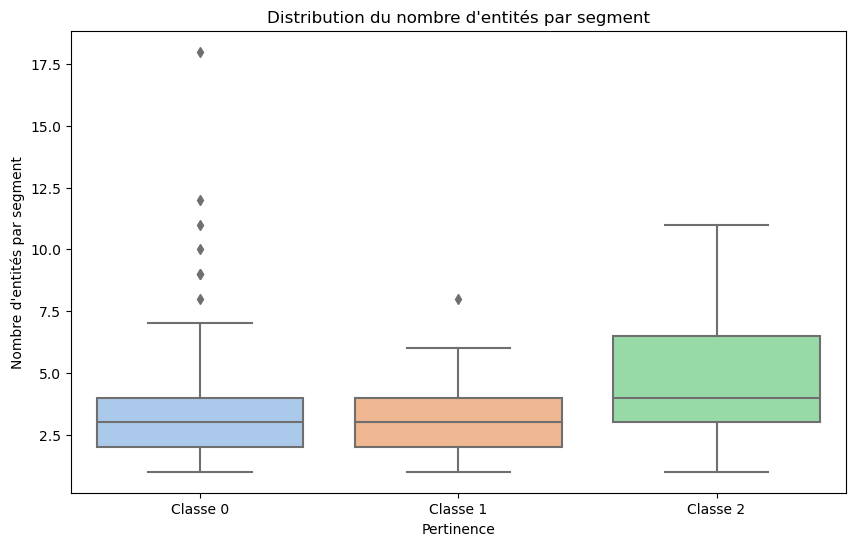

In [296]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que vos données sont dans un DataFrame nommé df

# Étape 1 : Compter le nombre de lignes par segment pour chaque relevance
segment_counts = df_entities_sub.groupby(['id_segment', 'relevance']).size().reset_index(name='count')

# Étape 2 : Créer un boxplot pour visualiser la distribution des comptes par relevance
plt.figure(figsize=(10, 6))
sns.boxplot(x='relevance', y='count', data=segment_counts, palette='pastel')

# Titre et labels
plt.title('Distribution du nombre d\'entités par segment')
plt.xlabel('Pertinence')
plt.ylabel('Nombre d\'entités par segment')
plt.xticks(ticks=[0, 1, 2], labels=['Classe 0', 'Classe 1', 'Classe 2'])
# Afficher le graphique
# Exporter la figure
plt.savefig('nombre_moyen_occurrences_labels.png', bbox_inches='tight', dpi=300)  # Spécifiez le nom du fichier et les 
plt.show()

<Axes: xlabel='count', ylabel='entity_label'>

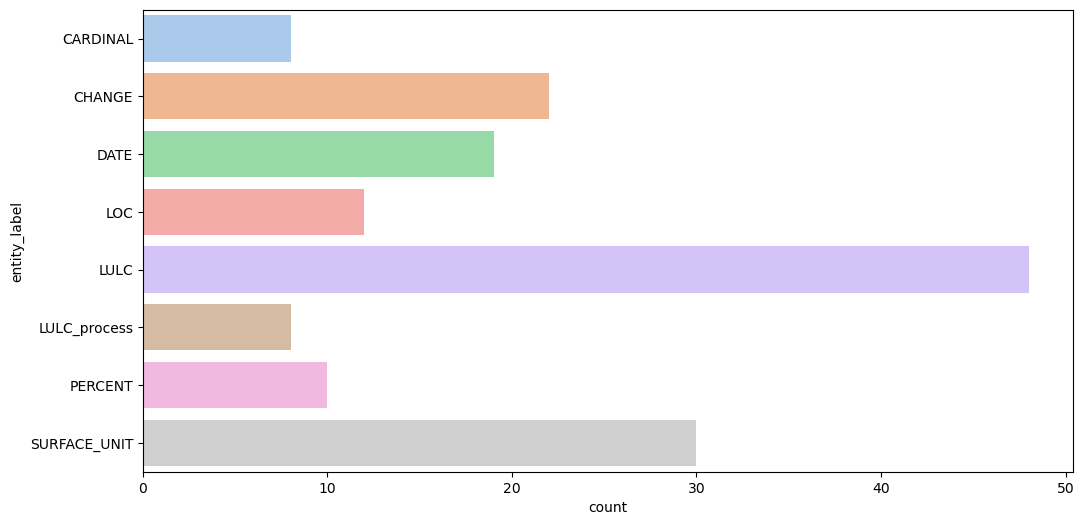

In [298]:
# Supposons que vos données sont dans un DataFrame nommé df

# Étape 1 : Compter le nombre d'occurrences de chaque label d'entité par segment
label_counts = df_entities_sub[df_entities_sub['relevance']==2].groupby(['id_segment', 'entity_label']).size().reset_index(name='count')

# Étape 2 : Calculer la moyenne des occurrences pour chaque label
mean_counts = label_counts.groupby('entity_label')['count'].sum().reset_index()

# Étape 3 : Créer un barplot des moyennes par label d'entité
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='entity_label', data=mean_counts, palette='pastel')


In [333]:
label_counts

,id_segment,entity_label,relevance,count
0,1-s2.0-S0006320709005400-main_115,LULC,0,2
1,1-s2.0-S0006320709005400-main_115,SURFACE_UNIT,0,1
2,1-s2.0-S0006320709005400-main_118,CHANGE,2,1
3,1-s2.0-S0006320709005400-main_118,LOC,2,1
4,1-s2.0-S0006320709005400-main_118,LULC,2,1
...,...,...,...,...
539,1-s2.0-S235198941500102X-main_247,LOC,2,1
540,1-s2.0-S235198941500102X-main_247,LULC,2,6
541,1-s2.0-S235198941500102X-main_42b,LOC,0,1
542,1-s2.0-S235198941500102X-main_42b,LULC_process,0,1


In [340]:
len(set(label_counts[(label_counts['relevance'] ==2)]['id_segment'].tolist()))

31

In [341]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'LULC_process') & (label_counts['count'] >0)]['id_segment'].tolist()))

8

In [342]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'PERCENT') & (label_counts['count'] >0)]['id_segment'].tolist()))

7

In [338]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'LOC') & (label_counts['count'] >0)]['id_segment'].tolist()))

10

In [339]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'DATE') & (label_counts['count'] >0)]['id_segment'].tolist()))

12

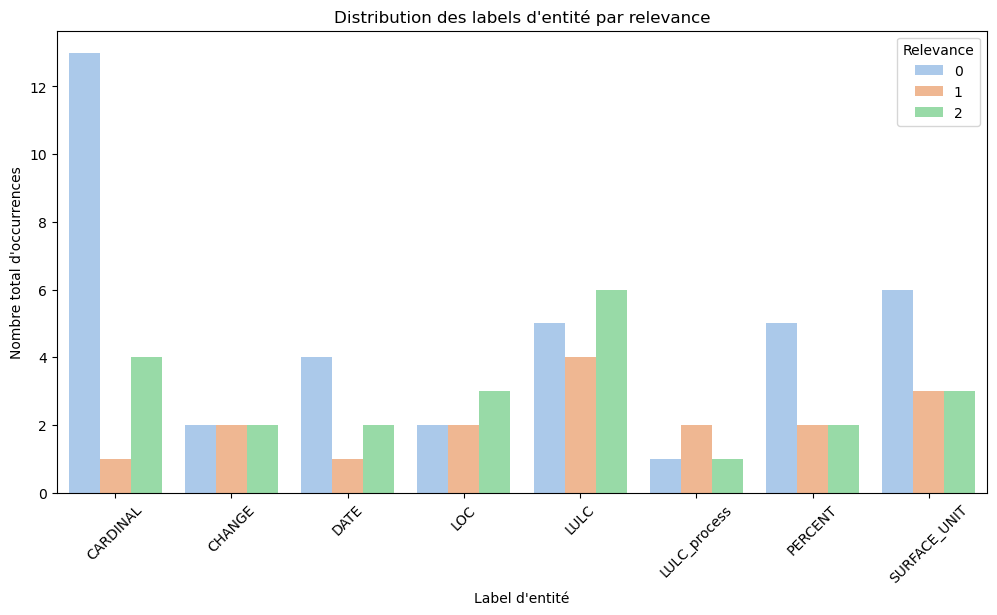

In [304]:

# Étape 1 : Compter le nombre d'occurrences de chaque label d'entité par segment pour chaque relevance
label_counts = df_entities_sub.groupby(['id_segment', 'entity_label', 'relevance']).size().reset_index(name='count')

# Étape 2 : Calculer la somme des occurrences pour chaque label par relevance
mean_counts = label_counts.groupby(['entity_label', 'relevance'])['count'].max().reset_index()

# Étape 3 : Créer un barplot des moyennes par label d'entité et relevance
plt.figure(figsize=(12, 6))
sns.barplot(x='entity_label', y='count', hue='relevance', data=mean_counts, palette='pastel')

# Titre et labels
plt.title('Distribution des labels d\'entité par relevance')
plt.xlabel('Label d\'entité')
plt.ylabel('Nombre total d\'occurrences')

# Ajuster la rotation des étiquettes pour la lisibilité
plt.xticks(rotation=45)

# Afficher la légende
plt.legend(title='Relevance')

# Afficher le graphique
plt.show()

In [325]:
df_labelled = pd.read_excel("C:/Users/valentin/Downloads/df_analysis.xlsx")

In [312]:
df_labelled.sort_values(by=['pred_label', 'prob_label_2'], ascending=False).iloc[0:10]['manual_label'].value_counts()

2.0    7
1.0    2
0.0    1
Name: manual_label, dtype: int64

In [314]:
df_labelled[df_labelled['pred_label']==2].sort_values(by=['pred_label', 'prob_label_2'], ascending=False)['manual_label'].value_counts()

2.0    13
1.0    12
0.0     5
Name: manual_label, dtype: int64

In [322]:
df_labelled[df_labelled['pred_label'].isin([1,0])].sort_values(by=['pred_label', 'prob_label_1'], ascending=False).iloc[0:20]['manual_label'].value_counts()

1.0    14
0.0     6
Name: manual_label, dtype: int64

In [311]:
df_labelled.sort_values(by='sim_miniLM_mean', ascending=False).iloc[0:10]['manual_label'].value_counts()

2.0    6
1.0    1
0.0    1
Name: manual_label, dtype: int64

In [323]:
df_labelled.sort_values(by='sim_miniLM_mean', ascending=False).iloc[0:50]['manual_label'].value_counts()

1.0    17
2.0    12
0.0     7
Name: manual_label, dtype: int64

In [326]:
df_labelled.sort_values(by='sim_roberta', ascending=False).iloc[0:10]['manual_label'].value_counts()

1.0    5
0.0    3
2.0    2
Name: manual_label, dtype: int64

In [327]:
df_labelled.sort_values(by='sim_roberta', ascending=False).iloc[0:50]['manual_label'].value_counts()

0.0    24
1.0    19
2.0     7
Name: manual_label, dtype: int64